IDEA:
We have table lookup for scrambles up to k=6

First make a network, might be pretrained

Then make a solver:
For a scramble of move n, apply n-k AI moves, and run table lookup on each state we reach (including before first AI move)
If a solution is found, return the scramble, else return False

Next, put them together.
We start by making an empty scramble list which we will use for training.
For a fixed n, first generate a scramble of that length.
Next, check if this is solvable using the solver.
If not, we add this scramble into the scramble list.
Repeat until we obtain N (=10 000) scrambles?
Then train on all these, and all subscrambles (i.e. all scrambles from length k to n).
This should ensure/make it so we don't lose the training on the smaller scramble sets
We repeat all this until we obtain a reasonable rate r (=80%?) for finding solutions for that n.

Finally, train by gradually increasing n.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

import random
import time

%run ../cube/Cube.ipynb

Support algs imported!
Cube initiated


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
def cube_to_tensor(cube, long_repr = True):
    '''
    removes center stickers, top corners
    (should I remove 1 whole corner and 3 edge stickers as well?)
    '''
    state = cube.state.tolist()
    short_state = state[0:4]
    short_state += state[5:13]
    short_state += state[14:22]
    short_state += state[23:31]
    short_state += state[32:36]
    short_state += [state[37],state[39],state[41],state[43],state[46],state[48],state[50],state[52]]
    if long_repr:
        long_state = np.zeros(len(short_state)*6)
        for i in range(len(short_state)):
            long_state[6*i:6*i+6] = np.array([0]*(short_state[i]-1) + [1] + [0]*(6-short_state[i]))
        tensor = torch.from_numpy(np.array(long_state, dtype=np.float32))
        return tensor.to(device)
    tensor = torch.from_numpy(np.array(long_state, dtype=np.float32))
    return tensor.to(device)

cuda


In [3]:
# Define the network architecture
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.fc1 = nn.Linear(240, 512)
#         self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 18)

    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, 2*in_features)
        self.fc2 = nn.Linear(2*in_features, in_features)
        self.fc3 = nn.Linear(in_features, out_features)

    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        out = self.fc2(out)
        out += x
        out = torch.relu(self.fc3(out))
        return out

class ResNet(nn.Module):
    def __init__(self, input_size=240, output_size=18, hidden_sizes=[512, 256, 128], num_blocks=4):
        super(ResNet, self).__init__()
        self.fc_input = nn.Linear(input_size, hidden_sizes[0])
        self.fc_output = nn.Linear(hidden_sizes[-1], output_size)

        self.residual_blocks = nn.ModuleList()
        for i in range(len(hidden_sizes)-1):
            self.residual_blocks.append(ResidualBlock(hidden_sizes[i],hidden_sizes[i+1]))

        self.fc_last = nn.Linear(hidden_sizes[-1], hidden_sizes[-1])

    def forward(self, x):
        out = self.fc_input(x)
        out = torch.relu(out)

        for residual_block in self.residual_blocks:
            out = residual_block(out)

        out = self.fc_last(out)
        out = torch.relu(out)

        out = self.fc_output(out)
        return out

# Create an instance of ResNet with input size 240, output size 18, and layer sizes [512, 256, 128]
network = ResNet(input_size=240, output_size=18, hidden_sizes=[512, 256, 128])

network = network.to(device)

In [4]:
def algs_to_dataset(algs, min_alg_length):
    # total number of data points: nr_of_algs*(max_alg_length - min_alg_length + 1)
    dataset = []
    for alg in algs:
        cube = Cube()
        cube.apply_moves(alg)
        alg_moves = alg.split(" ")
        for j in range(len(alg_moves)-1,min_alg_length-2,-1):
            inv = inverse_alg(alg_moves[j])
            target = torch.tensor([moves.index(inv)])
            target = target.to(device)
            dataset.append((cube_to_tensor(cube),target))
            cube.apply_moves(inv)
    return dataset

In [5]:
# def smart_dataset(nr_of_algs, data_exp, min_alg_length, max_alg_length):
#     # total number of data points: nr_of_algs*(max_alg_length - min_alg_length + 1)
#     dataset = []
#     for i in range(nr_of_algs):
#         alg = gen_random_alg(max_alg_length)
#         sub_algs = []
#         cube = Cube()
#         cube.apply_moves(alg)
#         for j in range(max_alg_length-1,min_alg_length-2,-1):
#             inv = inverse_alg(alg.split(" ")[j])
#             target = torch.tensor([moves.index(inv)])
#             target = target.to(device)
#             dataset.append((cube_to_tensor(cube),target))
#             cube.apply_moves(inv)
#     return dataset

In [6]:
# load table for table lookup
import pickle
with open('dict6.pkl', 'rb') as f:
    table = pickle.load(f)
    
def lookup_solver(cube):
    '''
    assumes there is some "table" to use
    '''
    ID = id_from_state(cube.state)
    if ID in table.keys():
        alg = table[ID]
        return alg
    return False

In [7]:
def evalute_cube(cube):
    state_tensor = cube_to_tensor(cube)
    output = network(state_tensor)
#     print(output)
    _, predicted_class = torch.max(output, dim=0)
    return predicted_class.item()

In [8]:
def AI_linear_solver(cube, iterations = 10):
    solution = ""
    last_move = "NO"
    for i in range(iterations):
        alg = lookup_solver(cube)
        if alg:
            cube.apply_moves(alg)
            return solution + alg
#         rot = reduce_symmetries(cube) # for the actual solver, we need to rotate back afterwards as well
        ev = evalute_cube(cube)
        move = moves[ev]
        solution += move+" "
        cube.apply_moves(move)
    alg = lookup_solver(cube)
    if alg:
        cube.apply_moves(alg)
        return solution + alg
    else:
        cube.apply_moves(inverse_alg(solution.strip()))
    return False

In [240]:
# training
n = 12 # nr of moves we want the training data on

k = 6 # max length in table lookup
# treshold = 0.75 # acceptance rate for the network being correct
nr_of_algs = 1000 # number of algs we want to train on

criterion = nn.CrossEntropyLoss() #CrossEntropyLoss MSELoss
optimizer = optim.SGD(network.parameters(), lr=0.001) #SGD   0.0005
u = 0.9993

correct_rate = 0
t = time.time()
its = 0
while True:
    network.eval()
    algs = []
    algs_genned = 0
    while len(algs) < nr_of_algs:
        # gen alg
        alg = gen_random_alg(n)
        algs_genned += 1
        
        # check if it can be solved using n-k-1 AI iterations + lookup (i.e. if it can be solved in fewer moves than n)
        cube = Cube()
        cube.apply_moves(alg)
        sol = AI_linear_solver(cube, n-k-1)
        # if no solution, append to algs so we can train on it
        if not sol:
            algs.append(alg)
    non_n_scrambles = algs_genned - nr_of_algs
    its += 1
    print(f"{its}. {nr_of_algs}/{algs_genned} scrambles genned. Solvable algs genned: {non_n_scrambles}")
    dataset = algs_to_dataset(algs, k+1)
    
    network.train()
    # Training loop
    total_loss = 0.0
    i = 0
    for input_data, target in dataset:
        # Forward pass
        output = network(input_data).unsqueeze(0)

        # Encode the target as class probabilities for MSELoss
#         target_onehot = F.one_hot(target, num_classes=18).float().squeeze() 
        
        # Compute the loss
        loss = criterion(output, target)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        i+=1  
    
    # Print average loss for the epoch
    average_loss = total_loss / len(dataset)
    print(f"Average Loss: {average_loss:.4f}, Time Spent: {int(time.time()-t)}s")
    optimizer.param_groups[0]['lr'] *= u
    print("Next Learning Rate:",optimizer.param_groups[0]['lr'])
    
network.eval()       

1. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 2.2639, Time Spent: 30s
Next Learning Rate: 0.0009993
2. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.2411, Time Spent: 59s
Next Learning Rate: 0.00099860049
3. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.2488, Time Spent: 89s
Next Learning Rate: 0.000997901469657
4. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 2.2907, Time Spent: 118s
Next Learning Rate: 0.00099720293862824
5. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 2.2706, Time Spent: 148s
Next Learning Rate: 0.0009965048965712001
6. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 2.2732, Time Spent: 177s
Next Learning Rate: 0.0009958073431436004
7. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 2.2713, Time Spent: 206s
Next Learning Rate: 0.0009951102780033998
8. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 2.2811, 

61. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 2.1916, Time Spent: 1784s
Next Learning Rate: 0.0009581844797340075
62. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 2.1971, Time Spent: 1813s
Next Learning Rate: 0.0009575137505981936
63. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 2.2066, Time Spent: 1843s
Next Learning Rate: 0.0009568434909727749
64. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 2.1900, Time Spent: 1872s
Next Learning Rate: 0.0009561737005290939
65. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 2.1854, Time Spent: 1900s
Next Learning Rate: 0.0009555043789387235
66. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 2.1960, Time Spent: 1929s
Next Learning Rate: 0.0009548355258734664
67. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.2200, Time Spent: 1958s
Next Learning Rate: 0.000954167141005355
68. 1000/1003 scrambles genned. Sol

Average Loss: 2.1362, Time Spent: 3484s
Next Learning Rate: 0.0009194042125926961
121. 1000/1000 scrambles genned. Solvable algs genned: 0
Average Loss: 2.1568, Time Spent: 3512s
Next Learning Rate: 0.0009187606296438812
122. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 2.1582, Time Spent: 3541s
Next Learning Rate: 0.0009181174972031304
123. 1000/1007 scrambles genned. Solvable algs genned: 7
Average Loss: 2.1514, Time Spent: 3570s
Next Learning Rate: 0.0009174748149550882
124. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.1268, Time Spent: 3598s
Next Learning Rate: 0.0009168325825846196
125. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 2.1571, Time Spent: 3627s
Next Learning Rate: 0.0009161907997768103
126. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.1691, Time Spent: 3656s
Next Learning Rate: 0.0009155494662169665
127. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 2.1260, Time 

Average Loss: 2.0864, Time Spent: 5181s
Next Learning Rate: 0.0008821934857135781
180. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 2.0754, Time Spent: 5210s
Next Learning Rate: 0.0008815759502735785
181. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 2.1120, Time Spent: 5239s
Next Learning Rate: 0.000880958847108387
182. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 2.0881, Time Spent: 5268s
Next Learning Rate: 0.000880342175915411
183. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 2.0969, Time Spent: 5297s
Next Learning Rate: 0.0008797259363922702
184. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 2.0949, Time Spent: 5326s
Next Learning Rate: 0.0008791101282367955
185. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.1041, Time Spent: 5355s
Next Learning Rate: 0.0008784947511470297
186. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 2.1004, Time Sp

239. 1000/1007 scrambles genned. Solvable algs genned: 7
Average Loss: 2.0500, Time Spent: 6907s
Next Learning Rate: 0.0008458962334966425
240. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.0703, Time Spent: 6936s
Next Learning Rate: 0.0008453041061331949
241. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 2.0764, Time Spent: 6964s
Next Learning Rate: 0.0008447123932589016
242. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 2.0893, Time Spent: 6993s
Next Learning Rate: 0.0008441210945836204
243. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 2.0441, Time Spent: 7022s
Next Learning Rate: 0.0008435302098174118
244. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 2.0695, Time Spent: 7051s
Next Learning Rate: 0.0008429397386705396
245. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.0681, Time Spent: 7079s
Next Learning Rate: 0.0008423496808534701
246. 1000/1003 scrambles ge

298. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.0417, Time Spent: 8605s
Next Learning Rate: 0.0008116605694855374
299. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.0655, Time Spent: 8633s
Next Learning Rate: 0.0008110924070868974
300. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 2.0637, Time Spent: 8662s
Next Learning Rate: 0.0008105246424019365
301. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.0316, Time Spent: 8691s
Next Learning Rate: 0.0008099572751522552
302. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 2.0806, Time Spent: 8719s
Next Learning Rate: 0.0008093903050596485
303. 1000/1000 scrambles genned. Solvable algs genned: 0
Average Loss: 2.0291, Time Spent: 8748s
Next Learning Rate: 0.0008088237318461068
304. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 2.0376, Time Spent: 8777s
Next Learning Rate: 0.0008082575552338145
305. 1000/1007 scrambles ge

357. 1000/1008 scrambles genned. Solvable algs genned: 8
Average Loss: 2.0432, Time Spent: 10303s
Next Learning Rate: 0.0007788105135949888
358. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.0154, Time Spent: 10332s
Next Learning Rate: 0.0007782653462354722
359. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9966, Time Spent: 10361s
Next Learning Rate: 0.0007777205604931074
360. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.9984, Time Spent: 10390s
Next Learning Rate: 0.0007771761561007622
361. 1000/1000 scrambles genned. Solvable algs genned: 0
Average Loss: 2.0217, Time Spent: 10418s
Next Learning Rate: 0.0007766321327914916
362. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 2.0302, Time Spent: 10447s
Next Learning Rate: 0.0007760884902985375
363. 1000/1009 scrambles genned. Solvable algs genned: 9
Average Loss: 2.0219, Time Spent: 10476s
Next Learning Rate: 0.0007755452283553286
364. 1000/1002 scram

416. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9992, Time Spent: 12005s
Next Learning Rate: 0.0007472899865895213
417. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 2.0126, Time Spent: 12034s
Next Learning Rate: 0.0007467668835989086
418. 1000/1007 scrambles genned. Solvable algs genned: 7
Average Loss: 2.0169, Time Spent: 12063s
Next Learning Rate: 0.0007462441467803893
419. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 2.0019, Time Spent: 12092s
Next Learning Rate: 0.000745721775877643
420. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.9950, Time Spent: 12120s
Next Learning Rate: 0.0007451997706345286
421. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9856, Time Spent: 12149s
Next Learning Rate: 0.0007446781307950844
422. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 2.0126, Time Spent: 12178s
Next Learning Rate: 0.0007441568561035279
423. 1000/1001 scramb

475. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 2.0192, Time Spent: 13702s
Next Learning Rate: 0.0007170451789090484
476. 1000/1007 scrambles genned. Solvable algs genned: 7
Average Loss: 1.9938, Time Spent: 13731s
Next Learning Rate: 0.0007165432472838121
477. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9788, Time Spent: 13760s
Next Learning Rate: 0.0007160416670107134
478. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9928, Time Spent: 13789s
Next Learning Rate: 0.0007155404378438059
479. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 1.9938, Time Spent: 13818s
Next Learning Rate: 0.0007150395595373152
480. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 1.9738, Time Spent: 13847s
Next Learning Rate: 0.0007145390318456391
481. 1000/1007 scrambles genned. Solvable algs genned: 7
Average Loss: 1.9721, Time Spent: 13875s
Next Learning Rate: 0.0007140388545233471
482. 1000/1007 scram

534. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.9788, Time Spent: 15402s
Next Learning Rate: 0.0006880244588090928
535. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 1.9950, Time Spent: 15430s
Next Learning Rate: 0.0006875428416879264
536. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9776, Time Spent: 15459s
Next Learning Rate: 0.0006870615616987448
537. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9818, Time Spent: 15488s
Next Learning Rate: 0.0006865806186055557
538. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 1.9386, Time Spent: 15517s
Next Learning Rate: 0.0006861000121725318
539. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.9754, Time Spent: 15545s
Next Learning Rate: 0.000685619742164011
540. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9565, Time Spent: 15574s
Next Learning Rate: 0.0006851398083444961
541. 1000/1005 scramb

593. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9543, Time Spent: 17098s
Next Learning Rate: 0.0006601782842188092
594. 1000/1008 scrambles genned. Solvable algs genned: 8
Average Loss: 1.9769, Time Spent: 17127s
Next Learning Rate: 0.000659716159419856
595. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.9694, Time Spent: 17156s
Next Learning Rate: 0.0006592543581082621
596. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9682, Time Spent: 17185s
Next Learning Rate: 0.0006587928800575863
597. 1000/1009 scrambles genned. Solvable algs genned: 9
Average Loss: 1.9625, Time Spent: 17214s
Next Learning Rate: 0.000658331725041546
598. 1000/1007 scrambles genned. Solvable algs genned: 7
Average Loss: 1.9720, Time Spent: 17243s
Next Learning Rate: 0.0006578708928340169
599. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9640, Time Spent: 17272s
Next Learning Rate: 0.0006574103832090331
600. 1000/1003 scrambl

652. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.9388, Time Spent: 18799s
Next Learning Rate: 0.0006334591181663546
653. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9761, Time Spent: 18828s
Next Learning Rate: 0.0006330156967836381
654. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9367, Time Spent: 18857s
Next Learning Rate: 0.0006325725857958895
655. 1000/1009 scrambles genned. Solvable algs genned: 9
Average Loss: 1.9230, Time Spent: 18886s
Next Learning Rate: 0.0006321297849858323
656. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 1.9592, Time Spent: 18915s
Next Learning Rate: 0.0006316872941363423
657. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 1.9274, Time Spent: 18944s
Next Learning Rate: 0.0006312451130304468
658. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9075, Time Spent: 18973s
Next Learning Rate: 0.0006308032414513254
659. 1000/1003 scram

711. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9308, Time Spent: 20501s
Next Learning Rate: 0.0006078213476272088
712. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 1.9077, Time Spent: 20530s
Next Learning Rate: 0.0006073958726838698
713. 1000/1007 scrambles genned. Solvable algs genned: 7
Average Loss: 1.9410, Time Spent: 20559s
Next Learning Rate: 0.000606970695572991
714. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9213, Time Spent: 20588s
Next Learning Rate: 0.0006065458160860899
715. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 1.9224, Time Spent: 20617s
Next Learning Rate: 0.0006061212340148296
716. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.9522, Time Spent: 20646s
Next Learning Rate: 0.0006056969491510191
717. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9279, Time Spent: 20675s
Next Learning Rate: 0.0006052729612866134
718. 1000/1001 scramb

770. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 1.9176, Time Spent: 22203s
Next Learning Rate: 0.0005832212056569289
771. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.9289, Time Spent: 22232s
Next Learning Rate: 0.000582812950812969
772. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.8797, Time Spent: 22261s
Next Learning Rate: 0.0005824049817473999
773. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 1.9031, Time Spent: 22290s
Next Learning Rate: 0.0005819972982601767
774. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 1.9127, Time Spent: 22319s
Next Learning Rate: 0.0005815899001513945
775. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 1.9336, Time Spent: 22348s
Next Learning Rate: 0.0005811827872212884
776. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.8905, Time Spent: 22377s
Next Learning Rate: 0.0005807759592702335
777. 1000/1009 scramb

829. 1000/1005 scrambles genned. Solvable algs genned: 5
Average Loss: 1.9008, Time Spent: 23903s
Next Learning Rate: 0.0005596166966753889
830. 1000/1006 scrambles genned. Solvable algs genned: 6
Average Loss: 1.9049, Time Spent: 23932s
Next Learning Rate: 0.0005592249649877161
831. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.9055, Time Spent: 23961s
Next Learning Rate: 0.0005588335075122247
832. 1000/1007 scrambles genned. Solvable algs genned: 7
Average Loss: 1.9035, Time Spent: 23990s
Next Learning Rate: 0.0005584423240569662
833. 1000/1003 scrambles genned. Solvable algs genned: 3
Average Loss: 1.9126, Time Spent: 24019s
Next Learning Rate: 0.0005580514144301263
834. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9201, Time Spent: 24048s
Next Learning Rate: 0.0005576607784400252
835. 1000/1008 scrambles genned. Solvable algs genned: 8
Average Loss: 1.9304, Time Spent: 24076s
Next Learning Rate: 0.0005572704158951172
836. 1000/1006 scram

888. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9270, Time Spent: 25604s
Next Learning Rate: 0.0005369675247749688
889. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 1.9326, Time Spent: 25634s
Next Learning Rate: 0.0005365916475076263
890. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.9345, Time Spent: 25663s
Next Learning Rate: 0.000536216033354371
891. 1000/1009 scrambles genned. Solvable algs genned: 9
Average Loss: 1.8828, Time Spent: 25692s
Next Learning Rate: 0.0005358406821310229
892. 1000/1002 scrambles genned. Solvable algs genned: 2
Average Loss: 1.8805, Time Spent: 25721s
Next Learning Rate: 0.0005354655936535311
893. 1000/1004 scrambles genned. Solvable algs genned: 4
Average Loss: 1.8954, Time Spent: 25750s
Next Learning Rate: 0.0005350907677379737
894. 1000/1001 scrambles genned. Solvable algs genned: 1
Average Loss: 1.9239, Time Spent: 25778s
Next Learning Rate: 0.000534716204200557
895. 1000/1008 scrambl

KeyboardInterrupt: 

In [13]:
'''
1: ResnetModel(240, 512, 256, 5, 18, False)
2: ResnetModel(240, 1024, 512, 5, 18, False)
3: ResnetModel(240, 4096, 1024, 5, 18, False) MSELoss
4: ResnetModel(240, 4096, 1024, 5, 18, False) CrossEntropyLoss
'''

# # Specify a path
PATH = "nn_s12_4.pt" #replace after use to not overwrite

# Save
# torch.save(network.state_dict(), PATH)
# Load
# network = SimpleNetwork()
network.load_state_dict(torch.load(PATH))




<All keys matched successfully>

In [14]:
network.eval()
def evalute_cube(cube):
    state_tensor = cube_to_tensor(cube)
    output = network(state_tensor)
#     print(output)
    _, predicted_class = torch.max(output, dim=0)
    return predicted_class.item()

n = 1000
correct = 0
t = time.time()
for i in range(n):
    length = gen_random_length(1,1,18)
    alg = gen_random_alg(length)
    cube = Cube()
    cube.apply_moves(alg)
    ev = evalute_cube(cube)
#     print(alg,"-",moves[ev])
    correct += int(ev==moves.index(inverse_alg(alg.split(" ")[-1])))
print(100*correct/n,"%")
print(time.time()-t)

'''
FIX! R L gets removed, only L R stays. For example: Check if next last move is opposite of this move, and add to training data.
'''

48.9 %
2.4360759258270264


'\nFIX! R L gets removed, only L R stays. For example: Check if next last move is opposite of this move, and add to training data.\n'

In [15]:
percentages = []
n = 1000
for j in range(20):
    correct = 0
    t = time.time()
    for i in range(n):
        length = j+1
        alg = gen_random_alg(length)
        cube = Cube()
        cube.apply_moves(alg)
        ev = evalute_cube(cube)
        correct += int(ev==moves.index(inverse_alg(alg.split(" ")[-1])))
    percentages.append(f"{j+1}: {100*correct/n}%")

print(percentages)

['1: 100.0%', '2: 90.7%', '3: 90.0%', '4: 87.9%', '5: 84.4%', '6: 76.9%', '7: 65.5%', '8: 57.6%', '9: 46.4%', '10: 35.3%', '11: 30.3%', '12: 22.3%', '13: 18.7%', '14: 14.7%', '15: 13.7%', '16: 11.3%', '17: 9.3%', '18: 9.7%', '19: 8.9%', '20: 8.7%']


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class ResnetModel(nn.Module):
    def __init__(self, state_dim: int, h1_dim: int, resnet_dim: int, num_resnet_blocks: int,
                 out_dim: int, batch_norm: bool):
        super().__init__()
        self.state_dim: int = state_dim
        self.blocks = nn.ModuleList()
        self.num_resnet_blocks: int = num_resnet_blocks
        self.batch_norm = batch_norm

        # first two hidden layers
        self.fc1 = nn.Linear(self.state_dim, h1_dim)

        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(h1_dim)

        self.fc2 = nn.Linear(h1_dim, resnet_dim)

        if self.batch_norm:
            self.bn2 = nn.BatchNorm1d(resnet_dim)

        # resnet blocks
        for block_num in range(self.num_resnet_blocks):
            if self.batch_norm:
                res_fc1 = nn.Linear(resnet_dim, resnet_dim)
                res_bn1 = nn.BatchNorm1d(resnet_dim)
                res_fc2 = nn.Linear(resnet_dim, resnet_dim)
                res_bn2 = nn.BatchNorm1d(resnet_dim)
                self.blocks.append(nn.ModuleList([res_fc1, res_bn1, res_fc2, res_bn2]))
            else:
                res_fc1 = nn.Linear(resnet_dim, resnet_dim)
                res_fc2 = nn.Linear(resnet_dim, resnet_dim)
                self.blocks.append(nn.ModuleList([res_fc1, res_fc2]))

        # output
        self.fc_out = nn.Linear(resnet_dim, out_dim)

    def forward(self, states_nnet):
        x = states_nnet

        # preprocess input
        x = x.float()

        # first two hidden layers
        x = self.fc1(x)
        if self.batch_norm:
            x = self.bn1(x)

        x = F.relu(x)
        x = self.fc2(x)
        if self.batch_norm:
            x = self.bn2(x)

        x = F.relu(x)

        # resnet blocks
        for block_num in range(self.num_resnet_blocks):
            res_inp = x
            if self.batch_norm:
                x = self.blocks[block_num][0](x)
                x = self.blocks[block_num][1](x)
                x = F.relu(x)
                x = self.blocks[block_num][2](x)
                x = self.blocks[block_num][3](x)
            else:
                x = self.blocks[block_num][0](x)
                x = F.relu(x)
                x = self.blocks[block_num][1](x)

            x = F.relu(x + res_inp)

        # output
        x = self.fc_out(x)
        return x

In [10]:
network = ResnetModel(240, 4096, 1024, 5, 18, False)
network = network.to(device)

In [11]:
network(input_data)

NameError: name 'input_data' is not defined

# Testing networks

In [116]:
def random_dataset(dataset_size, data_exp, min_alg_length, max_alg_length):
    # Define a dataset (input-output pairs)
    dataset = []
    for i in range(dataset_size):
        length = gen_random_length(data_exp, min_alg_length, max_alg_length)
        alg = gen_random_alg(length)
        cube = Cube(0)
        cube.apply_moves(alg)
        dataset.append((cube_to_tensor_2(cube),torch.tensor([moves.index(inverse_alg(alg.split(" ")[-1]))])))
    return dataset

def smart_dataset(nr_of_algs, data_exp, min_alg_length, max_alg_length):
    # total number of data points: nr_of_algs*(max_alg_length - min_alg_length + 1)
    dataset = []
    for i in range(nr_of_algs):
        alg = gen_random_alg(max_alg_length)
        sub_algs = []
        cube = Cube()
        cube.apply_moves(alg)
        for j in range(max_alg_length-1,min_alg_length-2,-1):
            inv = inverse_alg(alg.split(" ")[j])
            dataset.append((cube_to_tensor_2(cube),torch.tensor([moves.index(inv)])))
            cube.apply_moves(inv)
    return dataset

def smart_dataset_2(nr_of_algs, data_exp, min_alg_length, max_alg_length):
    # total number of data points: nr_of_algs*(max_alg_length - min_alg_length + 1)
    dataset = []
    for i in range(nr_of_algs):
        alg = gen_random_alg(max_alg_length)
        sub_algs = []
        cube = Cube()
        cube.apply_moves(alg)
        for j in range(max_alg_length-1,min_alg_length-2,-1):
            inv = inverse_alg(alg.split(" ")[j])
            dataset.append((cube_to_tensor_2(cube).unsqueeze(0),torch.tensor([moves.index(inv)])))
            cube.apply_moves(inv)
    return dataset

# r_dataset = random_dataset(dataset_size, data_exp, min_alg_length, max_alg_length)
# s_dataset = smart_dataset(nr_of_algs, data_exp, min_alg_length, max_alg_length)
# len(r_dataset),len(s_dataset)

In [124]:
# Resnet 1

import torch
import torch.nn as nn

class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = nn.Sequential(
            nn.Linear(240, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 18)
        )

    def forward(self, x):
        out = self.resnet(x)
        return out

# Example usage
network = ResNetModel()

In [113]:
# # Resnet 2

# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm1d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm1d(out_channels)
#         self.downsample = nn.Sequential(
#             nn.Conv1d(in_channels, out_channels, kernel_size=1),
#             nn.BatchNorm1d(out_channels)
#         )

#     def forward(self, x):
#         identity = x
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.conv2(out)
#         out = self.bn2(out)
#         if x.shape != out.shape:
#             identity = self.downsample(x)
#         out += identity
#         out = self.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(ResNet, self).__init__()
#         self.conv = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3)
#         self.bn = nn.BatchNorm1d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

#         self.layer1 = self._make_layer(64, 64, num_blocks=2)
#         self.layer2 = self._make_layer(64, 128, num_blocks=2)
#         self.layer3 = self._make_layer(128, 256, num_blocks=2)
#         self.layer4 = self._make_layer(256, 512, num_blocks=2)

#         self.avgpool = nn.AdaptiveAvgPool1d(1)
#         self.fc = nn.Linear(512, num_classes)

#     def _make_layer(self, in_channels, out_channels, num_blocks):
#         layers = []
#         layers.append(ResidualBlock(in_channels, out_channels))
#         for _ in range(1, num_blocks):
#             layers.append(ResidualBlock(out_channels, out_channels))
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# # Create the ResNet model
# input_size = 240
# num_classes = 18  # Including 0 to 17 (total 18 classes)
# network = ResNet(input_size, num_classes)

In [149]:
# Train
# trains by making a "small" dataset and training on it 5 times. Repeat N times
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss()

optimizer = optim.SGD(network.parameters(), lr=0.0001) #SGD
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.005)
# scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=100, cycle_momentum=False)
u = 0.999


N = 5000
dataset_size = 5000
num_epochs = 1
data_exp = 1
min_alg_length = 7
max_alg_length = 14
nr_of_algs = dataset_size//(max_alg_length - min_alg_length + 1) # gives approx. dataset_size nr of data points
print(f"Training on {N}*{dataset_size} data points {num_epochs} times, totaling {N*dataset_size*num_epochs} data points.")


Training on 5000*5000 data points 1 times, totaling 25000000 data points.


In [150]:
network.train()

t = time.time()
for rep in range(N):
    dataset = smart_dataset(nr_of_algs, data_exp, min_alg_length, max_alg_length)
    print(f"Dataset {rep+1} created")
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        i = 0
        for input_data, target in dataset:
            # Forward pass
            output = network(input_data)

            # Encode the target as class probabilities
            target_onehot = F.one_hot(target, num_classes=18).float().squeeze()

            # Compute the loss
            loss = criterion(output, target_onehot)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            i+=1

        # Print average loss for the epoch
        average_loss = total_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}, Time Spent: {int(time.time()-t)}s")
    
    optimizer.param_groups[0]['lr'] *= u
    print(optimizer.param_groups[0]['lr'])
    print(f"{rep+1}/{N} done, time elapsed since training start: {int(time.time()-t)}s")

network.eval()

Dataset 1 created
Epoch [1/1], Average Loss: 2.1017, Time Spent: 8s
9.99e-05
1/5000 done, time elapsed since training start: 8s
Dataset 2 created
Epoch [1/1], Average Loss: 2.0755, Time Spent: 18s
9.980010000000001e-05
2/5000 done, time elapsed since training start: 18s
Dataset 3 created
Epoch [1/1], Average Loss: 2.1148, Time Spent: 26s
9.970029990000001e-05
3/5000 done, time elapsed since training start: 26s
Dataset 4 created
Epoch [1/1], Average Loss: 2.1150, Time Spent: 36s
9.960059960010001e-05
4/5000 done, time elapsed since training start: 36s
Dataset 5 created
Epoch [1/1], Average Loss: 2.1039, Time Spent: 46s
9.950099900049991e-05
5/5000 done, time elapsed since training start: 46s
Dataset 6 created
Epoch [1/1], Average Loss: 2.0986, Time Spent: 55s
9.94014980014994e-05
6/5000 done, time elapsed since training start: 55s
Dataset 7 created
Epoch [1/1], Average Loss: 2.1312, Time Spent: 64s
9.930209650349791e-05
7/5000 done, time elapsed since training start: 64s
Dataset 8 creat

112/5000 done, time elapsed since training start: 908s
Dataset 113 created
Epoch [1/1], Average Loss: 2.0989, Time Spent: 916s
8.931001648639149e-05
113/5000 done, time elapsed since training start: 916s
Dataset 114 created
Epoch [1/1], Average Loss: 2.1007, Time Spent: 924s
8.92207064699051e-05
114/5000 done, time elapsed since training start: 924s
Dataset 115 created
Epoch [1/1], Average Loss: 2.1139, Time Spent: 932s
8.913148576343518e-05
115/5000 done, time elapsed since training start: 932s
Dataset 116 created
Epoch [1/1], Average Loss: 2.0787, Time Spent: 940s
8.904235427767175e-05
116/5000 done, time elapsed since training start: 940s
Dataset 117 created
Epoch [1/1], Average Loss: 2.1398, Time Spent: 948s
8.895331192339408e-05
117/5000 done, time elapsed since training start: 948s
Dataset 118 created
Epoch [1/1], Average Loss: 2.0914, Time Spent: 956s
8.886435861147069e-05
118/5000 done, time elapsed since training start: 956s
Dataset 119 created
Epoch [1/1], Average Loss: 2.100

Epoch [1/1], Average Loss: 2.0854, Time Spent: 1766s
8.016280363938306e-05
221/5000 done, time elapsed since training start: 1766s
Dataset 222 created
Epoch [1/1], Average Loss: 2.0970, Time Spent: 1773s
8.008264083574368e-05
222/5000 done, time elapsed since training start: 1773s
Dataset 223 created
Epoch [1/1], Average Loss: 2.0815, Time Spent: 1781s
8.000255819490794e-05
223/5000 done, time elapsed since training start: 1781s
Dataset 224 created
Epoch [1/1], Average Loss: 2.0824, Time Spent: 1789s
7.992255563671303e-05
224/5000 done, time elapsed since training start: 1789s
Dataset 225 created
Epoch [1/1], Average Loss: 2.1049, Time Spent: 1797s
7.984263308107632e-05
225/5000 done, time elapsed since training start: 1797s
Dataset 226 created
Epoch [1/1], Average Loss: 2.0974, Time Spent: 1805s
7.976279044799524e-05
226/5000 done, time elapsed since training start: 1805s
Dataset 227 created
Epoch [1/1], Average Loss: 2.0997, Time Spent: 1813s
7.968302765754725e-05
227/5000 done, time

Epoch [1/1], Average Loss: 2.0976, Time Spent: 2616s
7.195245662400539e-05
329/5000 done, time elapsed since training start: 2616s
Dataset 330 created
Epoch [1/1], Average Loss: 2.1205, Time Spent: 2623s
7.188050416738138e-05
330/5000 done, time elapsed since training start: 2623s
Dataset 331 created
Epoch [1/1], Average Loss: 2.0850, Time Spent: 2631s
7.1808623663214e-05
331/5000 done, time elapsed since training start: 2631s
Dataset 332 created
Epoch [1/1], Average Loss: 2.0940, Time Spent: 2639s
7.173681503955078e-05
332/5000 done, time elapsed since training start: 2639s
Dataset 333 created
Epoch [1/1], Average Loss: 2.1049, Time Spent: 2647s
7.166507822451122e-05
333/5000 done, time elapsed since training start: 2647s
Dataset 334 created
Epoch [1/1], Average Loss: 2.0969, Time Spent: 2654s
7.15934131462867e-05
334/5000 done, time elapsed since training start: 2654s
Dataset 335 created
Epoch [1/1], Average Loss: 2.0886, Time Spent: 2662s
7.152181973314041e-05
335/5000 done, time el

Epoch [1/1], Average Loss: 2.0716, Time Spent: 3477s
6.458302079252498e-05
437/5000 done, time elapsed since training start: 3477s
Dataset 438 created
Epoch [1/1], Average Loss: 2.1013, Time Spent: 3486s
6.451843777173246e-05
438/5000 done, time elapsed since training start: 3486s
Dataset 439 created
Epoch [1/1], Average Loss: 2.0737, Time Spent: 3494s
6.445391933396073e-05
439/5000 done, time elapsed since training start: 3494s
Dataset 440 created
Epoch [1/1], Average Loss: 2.0808, Time Spent: 3502s
6.438946541462677e-05
440/5000 done, time elapsed since training start: 3502s
Dataset 441 created
Epoch [1/1], Average Loss: 2.1018, Time Spent: 3512s
6.432507594921215e-05
441/5000 done, time elapsed since training start: 3512s
Dataset 442 created
Epoch [1/1], Average Loss: 2.0979, Time Spent: 3521s
6.426075087326294e-05
442/5000 done, time elapsed since training start: 3521s
Dataset 443 created
Epoch [1/1], Average Loss: 2.0980, Time Spent: 3529s
6.419649012238967e-05
443/5000 done, time

Epoch [1/1], Average Loss: 2.0594, Time Spent: 4429s
5.7968369259211056e-05
545/5000 done, time elapsed since training start: 4429s
Dataset 546 created
Epoch [1/1], Average Loss: 2.1020, Time Spent: 4439s
5.791040088995184e-05
546/5000 done, time elapsed since training start: 4439s
Dataset 547 created
Epoch [1/1], Average Loss: 2.1019, Time Spent: 4448s
5.785249048906189e-05
547/5000 done, time elapsed since training start: 4448s
Dataset 548 created
Epoch [1/1], Average Loss: 2.0671, Time Spent: 4456s
5.7794637998572825e-05
548/5000 done, time elapsed since training start: 4456s
Dataset 549 created
Epoch [1/1], Average Loss: 2.1072, Time Spent: 4464s
5.773684336057425e-05
549/5000 done, time elapsed since training start: 4464s
Dataset 550 created
Epoch [1/1], Average Loss: 2.0934, Time Spent: 4472s
5.767910651721368e-05
550/5000 done, time elapsed since training start: 4472s
Dataset 551 created
Epoch [1/1], Average Loss: 2.0949, Time Spent: 4480s
5.7621427410696465e-05
551/5000 done, t

Epoch [1/1], Average Loss: 2.0907, Time Spent: 5343s
5.203119633204241e-05
653/5000 done, time elapsed since training start: 5343s
Dataset 654 created
Epoch [1/1], Average Loss: 2.1030, Time Spent: 5351s
5.197916513571037e-05
654/5000 done, time elapsed since training start: 5351s
Dataset 655 created
Epoch [1/1], Average Loss: 2.0970, Time Spent: 5359s
5.192718597057466e-05
655/5000 done, time elapsed since training start: 5359s
Dataset 656 created
Epoch [1/1], Average Loss: 2.0833, Time Spent: 5368s
5.1875258784604084e-05
656/5000 done, time elapsed since training start: 5368s
Dataset 657 created
Epoch [1/1], Average Loss: 2.0616, Time Spent: 5376s
5.182338352581948e-05
657/5000 done, time elapsed since training start: 5376s
Dataset 658 created
Epoch [1/1], Average Loss: 2.0812, Time Spent: 5384s
5.177156014229366e-05
658/5000 done, time elapsed since training start: 5384s
Dataset 659 created
Epoch [1/1], Average Loss: 2.0897, Time Spent: 5393s
5.171978858215137e-05
659/5000 done, tim

KeyboardInterrupt: 

In [183]:
# # Specify a path
PATH = "nn_testt.pt" #replace after use to not overwrite

# # Save
# torch.save(network.state_dict(), PATH)
# network = ResNetModel()
# network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [107]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels)
        )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if x.shape != out.shape:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ResNet, self).__init__()
        self.conv = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, num_blocks=2)
        self.layer2 = self._make_layer(64, 128, num_blocks=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create the ResNet model
input_size = 240
num_classes = 18  # Including 0 to 17 (total 18 classes)
model = ResNet(input_size, num_classes)

# Generate random input tensor
input_tensor = torch.randint(0, 2, (1, 1, input_size)).float()

# Forward pass
output = model(input_tensor)
output


tensor([[-0.1216,  0.0193,  0.7977, -0.1878,  0.3387,  0.4995,  0.7464, -0.6312,
          0.1056, -0.2269, -0.4448,  0.1897,  0.0219,  0.0268, -0.6919, -0.3570,
         -0.1027,  0.0529]], grad_fn=<AddmmBackward0>)

In [111]:
scalar_tensor = torch.tensor(5)  # Scalar tensor of dimension []
list_tensor = scalar_tensor.unsqueeze(0)  # Transforming into [[]] by unsqueezing
list_tensor = list_tensor.unsqueeze(0)  # Transforming into [[]] by unsqueezing

print(list_tensor)
print(scalar_tensor)

tensor([[5]])
tensor(5)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Example usage
model = ResNet18()
input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor with shape (batch_size, channels, height, width)


# Forward pass
output = model(input_tensor)
print(output.shape)  # Output shape: (1, num_classes)

# Initialize the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Generate random test data
batch_size = 1
channels = 3
height = 224
width = 224
num_classes = 10


# Example training loop
for epoch in range(10):
    # ...load and prepare your training data...
    target_tensor = torch.tensor([random.randint(0,9)])

    # Forward pass
    output = model(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss or other metrics during training
    print('Epoch: {}, Loss: {:.4f}'.format(epoch, loss.item()))

# After training, you can use the trained model for inference
test_input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor for testing
model.eval()
with torch.no_grad():
    output = model(test_input_tensor)
    predicted_class = torch.argmax(output, dim=1)

print('Predicted class:', predicted_class.item())



torch.Size([1, 1000])
Epoch: 0, Loss: 6.7970
Epoch: 1, Loss: 6.9823
Epoch: 2, Loss: 7.0937
Epoch: 3, Loss: 7.4850
Epoch: 4, Loss: 5.4554
Epoch: 5, Loss: 7.2952
Epoch: 6, Loss: 5.6416
Epoch: 7, Loss: 4.5398
Epoch: 8, Loss: 5.0171
Epoch: 9, Loss: 2.7460
Predicted class: 0


In [43]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm1d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv1d(
                    in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm1d(out_channels * self.expansion),
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out


class ResNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlock, 512, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 64, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


# Define the input size and number of classes
input_size = 240
num_classes = 18  # 0 to 17 (18 classes in total)

# Create an instance of the ResNet model
network = ResNet(input_size, num_classes)

# Create random input tensor for demonstration
input_tensor = torch.randn(1,1,input_size)  # Example input tensor with shape (batch_size, 1, input_size)

# Forward pass
# print(input_tensor)
output = network(input_tensor)[0]
print(output)  # Output shape: (1, num_classes)


tensor([ 0.6600,  0.7657,  0.3886, -0.4003,  0.6522, -0.2796,  0.3820, -0.0923,
        -0.6773, -0.2975, -0.6874, -0.0036, -0.0055,  0.4915, -0.0099, -0.4279,
        -0.4902, -0.2987], grad_fn=<SelectBackward0>)


In [44]:
def algs_to_dataset(algs, min_alg_length):
    # total number of data points: nr_of_algs*(max_alg_length - min_alg_length + 1)
    dataset = []
    for alg in algs:
        cube = Cube()
        '''
        
        MÅ LEGGE INN ROTASJON HER?
        
        '''
        cube.apply_moves(alg)
        alg_moves = alg.split(" ")
        for j in range(len(alg_moves)-1,min_alg_length-2,-1):
            inv = inverse_alg(alg_moves[j])
            dataset.append((cube_to_tensor_2(cube).unsqueeze(0).unsqueeze(0),torch.tensor([moves.index(inv)])))
            cube.apply_moves(inv)
    return dataset

def evalute_cube(cube):
    state_tensor = cube_to_tensor_2(cube).unsqueeze(0).unsqueeze(0)
#     print(state_tensor)
    output = network(state_tensor)[0]
#     print(output)
    _, predicted_class = torch.max(output, dim=0)
    return predicted_class.item()

dataset = algs_to_dataset(["R U R' F L", "F L F L D L F"], 3+1)


In [68]:
# training
n = 7 # nr of moves we want the training data on

k = 6 # max length in table lookup
treshold = 0.9 # acceptance rate for the network being correct
nr_of_algs = 500 # number of algs we want to train on

criterion = nn.CrossEntropyLoss() #CrossEntropyLoss MSELoss
optimizer = optim.SGD(network.parameters(), lr=0.03) #SGD
u = 0.995

correct_rate = 0
t = time.time()
its = 0
while correct_rate < treshold:
    network.eval()
    algs = []
    algs_genned = 0
    while len(algs) < nr_of_algs:
        # gen alg
        alg = gen_random_alg(n)
        algs_genned += 1
        
        # check if it can be solved using n-k AI iterations + lookup 
        cube = Cube()
        cube.apply_moves(alg)
        
        sol = AI_linear_solver(cube, n-k)
        
        # if no solution, append to algs so we can train on it
        if not sol:
            algs.append(alg)
    correct_rate = (algs_genned-nr_of_algs)/algs_genned
    its += 1
    print(f"{its}. {nr_of_algs}/{algs_genned} scrambles genned. Correct rate: {100*correct_rate:.2f}%")
#     print(algs_genned, nr_of_algs)
    
#     algs = []
#     for i in range(1000):
#         algs.append(gen_random_alg(n))
    
    dataset = algs_to_dataset(algs, k+1)
#     print(len(dataset))
    
    network.train()
    # Training loop
    total_loss = 0.0
    i = 0
    for input_data, target in dataset:
        # Forward pass
        output = network(input_data)[0]

        # Encode the target as class probabilities
        target_onehot = F.one_hot(target, num_classes=18).float().squeeze()
        # Compute the loss
        loss = criterion(output, target_onehot)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        i+=1
    # Print average loss for the epoch
    average_loss = total_loss / len(dataset)
    print(f"Average Loss: {average_loss:.4f}, Time Spent: {int(time.time()-t)}s")
    optimizer.param_groups[0]['lr'] *= u
    print("Next Learning Rate:",optimizer.param_groups[0]['lr'])
    
network.eval()       

1. 500/536 scrambles genned. Correct rate: 6.72%
Average Loss: 3.2030, Time Spent: 31s
Next Learning Rate: 0.029849999999999998
2. 500/543 scrambles genned. Correct rate: 7.92%
Average Loss: 2.9459, Time Spent: 62s
Next Learning Rate: 0.029700749999999998
3. 500/541 scrambles genned. Correct rate: 7.58%
Average Loss: 2.9186, Time Spent: 94s
Next Learning Rate: 0.029552246249999997
4. 500/548 scrambles genned. Correct rate: 8.76%


KeyboardInterrupt: 

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm1d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv1d(
                    in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm1d(out_channels * self.expansion),
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out


class ResNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlock, 512, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128 * BasicBlock.expansion, num_classes)  # Adjusted for the final layer size

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


# Define the input size and number of classes
input_size = 240
num_classes = 18

# Create an instance of the ResNet model
network = ResNet(input_size, num_classes)

# Create random input tensor for demonstration
input_tensor = torch.randn(1, 1, 240)
                           
# Forward pass
output = network(input_tensor)
print(output)  # Output shape: (1, num_classes)


tensor([[ 5.7590e-01,  4.8106e-01, -6.7134e-01, -1.0616e+00, -8.4086e-01,
         -1.1614e-02,  2.8793e-01,  2.9160e-01,  2.9286e-01, -2.3108e-02,
         -1.3604e-01, -4.5624e-01, -1.1628e+00, -9.9339e-05, -3.6187e-01,
          5.4141e-01,  1.4932e-01, -2.4157e-01]], grad_fn=<AddmmBackward0>)


In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.fc2 = nn.Linear(out_channels, out_channels)
        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Linear(in_channels, out_channels),
            )

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 240
        self.fc1 = nn.Linear(input_size, 240)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer2 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.maxpool(out)
        out = out.permute(0, 2, 1)  # Adjust the dimension ordering
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc2(out)
        return out


# Define the input size and number of classes
input_size = 240
num_classes = 18

# Create an instance of the ResNet model
model = ResNet(input_size, num_classes)

# Create random input tensor for demonstration
batch_size = 1
sequence_length = 240
input_tensor = torch.randn(batch_size, sequence_length, input_size)

# Forward pass
output = model(input_tensor)
print(output.shape)  # Output shape: (1, num_classes)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x120 and 512x18)

In [97]:
def branch(cube, k = 2, smart_branching = True):
    '''
    k: branching factor
    smart_branching: if True, don't accept moves along the same layer. I.e. if R then R', replace R' with next
    
    returns the indexes of the moves in question
    '''
    state_tensor = cube_to_tensor(cube)
    output = network(state_tensor)
    if smart_branching:
        sorted_move_indexes = output.sort()[1]
        move_indexes = np.zeros(k, dtype = int)
        move_indexes[0] = sorted_move_indexes[-1]
        used_axes = [move_indexes[0]//3]
        j = 1
        for i in range(1,18): # 18 moves, first is already added
            idx = sorted_move_indexes[-i]
            if idx//3 not in used_axes:
                used_axes.append(idx//3)
                move_indexes[j] = idx
                j+=1
            if j==k:
                break
    else:
        move_indexes = torch.flip(output.sort()[1][-k:],dims=[-1]).numpy() 
    return [moves[i] for i in move_indexes]


scr = "F' U2 R U2 B' L2 U2 L B D' L D L U' D2 L B2 R'"
cube = Cube()
cube.apply_moves(scr)
branch(cube)

['F2', 'L']

In [139]:
TEST = [0,0]

def AI_branch_solver(cube, it = 5, k = 2, smart_branching = True, plot = False, last_moves = ["k","l"]):
    '''
    cube: scrambled cube
    k: branching factor
    smart_branching: if True, don't accept moves along the same layer. I.e. if R then R', replace R' with next
    '''
    alg = lookup_solver(cube)
    if alg:
        cube.apply_moves(alg)
        return alg
    if it == 0:
#         print("test",TEST[0])
#         cube.plot()
        return False
    
    branch_moves = branch(cube,k,smart_branching)
    
    for i in range(k):
        new_move = branch_moves[i]
        inv = inverse_alg(new_move)
        # check that this move does not cancel the last one, and that it does not move along the same axis as the previous two moves
        if (inv[0] != last_moves[0][0]):# and (new_move[0]!=last_moves[0][0] or new_move[0]!=last_moves[1][0]):
            cube.apply_moves(new_move)
            TEST[0]+=1
            sol = AI_branch_solver(cube, it-1, k, smart_branching, last_moves = [new_move,last_moves[0]])
            if cube.is_solved():
                return new_move+" "+sol
            cube.apply_moves(inv)
        else:
            TEST[1]+=1
    return False

it = 4
k = 2
scr = gen_random_alg(10)
cube = Cube()
print("Scramble:",scr)
cube.apply_moves(scr)
# cube.plot()
sol = AI_branch_solver(cube, it=it, k=k, smart_branching=True)
print("Solution:",sol)
# cube.plot()
TEST

Scramble: F' U' L' F2 B' U R2 F' U R2
Solution: False


[14, 4]

In [16]:
scr = gen_random_alg(10)
algs = gen_all_algs(3)

1 genned in 0.0
2 genned in 0.0009953975677490234
3 genned in 0.013967037200927734


F2 B' L D' F D2 F D' R' F2 R' U R2 L' F' R' F B2 R B2 R' B R F D' R2 U F2 U' D2


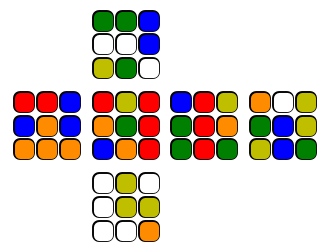

False


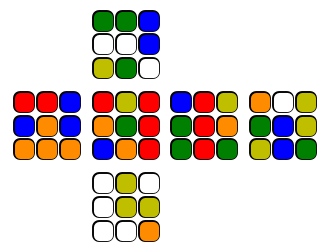

In [25]:
def evalute_cube(cube):
    state_tensor = cube_to_tensor(cube)
    output = network(state_tensor)
    _, predicted_class = torch.max(output, dim=0)
    return predicted_class.item()

def AI_linear_solver(cube, iterations = 10):
    solution = ""
    last_move = "NO"
    
    for i in range(iterations):
        alg = lookup_solver(cube)
        if alg:
            cube.apply_moves(alg)
            return solution + alg
        ev = evalute_cube(cube)
        move = moves[ev]
        solution += move+" "
        cube.apply_moves(move)
    alg = lookup_solver(cube)
    if alg:
        cube.apply_moves(alg)
        return solution + alg
    else:
#         cube.plot()
        cube.apply_moves(inverse_alg(solution.strip()))
    return False


def epic_solver(cube, AI_iterations = 10, algs = [""]):
    '''
    cube: scrambled cube that we want solved
    AI_iterations: nr of iterations for the AI
    cutoff: stop generating scrambles at this point
    '''
    
    # check if AI + table lookup solves this case
    sol0 = AI_linear_solver(cube,AI_iterations)
    if sol0:
        return sol0
    TEST = 0
    for alg in algs:
        TEST+=1
        inv = inverse_alg(alg)
        cube.apply_moves(alg)
        sol0 = AI_linear_solver(cube, AI_iterations)
        if sol0:
            return alg+" "+sol0
        cube.apply_moves(inv)
    return False
     
    
scr = gen_random_alg(30)
cube = Cube()
cube.apply_moves(scr)
print(scr)
cube.plot()
sol = epic_solver(cube, AI_iterations=12, algs = algs)
print(sol)
cube.plot()

In [157]:
t = time.time()
for i in range(10000):
    output = network(input_data)
print(time.time()-t)

10.518123865127563
